<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/Auto-Encoder/blob/main/Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  # Importing the google drive module, I saved the dataset in my google drive
#mounting drive to the colab environment to access the files in the drive
#Google drive will be mounted at '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzipping the main zip file in the drive
!unzip '/content/drive/My Drive/DATASET/denoising-dirty-documents.zip' -d /content/dataset/

# Now unzip the individual zip files inside /content/dataset/
# To unzip train.zip
!unzip '/content/dataset/train.zip' -d /content/dataset/train/
# To unzip train_cleaned.zip
!unzip '/content/dataset/train_cleaned.zip' -d /content/dataset/train_cleaned/
# To unzip test.zip
!unzip '/content/dataset/test.zip' -d /content/dataset/test/
# To unzip sampleSubmission.csv.zip
!unzip '/content/dataset/sampleSubmission.csv.zip' -d /content/dataset/sampleSubmission/

Archive:  /content/drive/My Drive/DATASET/denoising-dirty-documents.zip
  inflating: /content/dataset/sampleSubmission.csv.zip  
  inflating: /content/dataset/test.zip  
  inflating: /content/dataset/train.zip  
  inflating: /content/dataset/train_cleaned.zip  
Archive:  /content/dataset/train.zip
   creating: /content/dataset/train/train/
  inflating: /content/dataset/train/train/101.png  
  inflating: /content/dataset/train/train/102.png  
  inflating: /content/dataset/train/train/104.png  
  inflating: /content/dataset/train/train/105.png  
 extracting: /content/dataset/train/train/107.png  
 extracting: /content/dataset/train/train/108.png  
 extracting: /content/dataset/train/train/11.png  
  inflating: /content/dataset/train/train/110.png  
 extracting: /content/dataset/train/train/111.png  
  inflating: /content/dataset/train/train/113.png  
  inflating: /content/dataset/train/train/114.png  
 extracting: /content/dataset/train/train/116.png  
  inflating: /content/dataset/train

In [ ]:
# to check the contents extracted to '/content/dataset/' directory
!ls /content/dataset/

sampleSubmission	  test	    train	   train_cleaned.zip
sampleSubmission.csv.zip  test.zip  train_cleaned  train.zip


In [ ]:
# Import necessary libraries
import tensorflow as tf # Importing Tensorflow to build and train models
from tensorflow.keras import layers, models # To import layers and models
import time  # To measure training time and other time related tasks
from tensorflow.keras.callbacks import Callback  # To use a custom callback for training
import matplotlib.pyplot as plt  # For plotting graphs
import numpy as np  # Import to perform numerical operations and helful in working with arrays
from skimage.metrics import structural_similarity as ssim  # To calculate SSIM (Structural Similarity Index)
import pandas as pd # Data manipulation and analysis
import os # For file handling and directory navigation
import warnings # To suppress specific warnings
# Suppress the specific UserWarning from Keras
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call `super\\(\\).__init__\\(\\*\\*kwargs\\)`")

In [ ]:
# Preprocessing the image dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# To set the paths to the unzipped directories
train_dir = '/content/dataset/train/'  # For noisy training images directory
train_cleaned_dir = '/content/dataset/train_cleaned/' # For clean training images directory
test_dir = '/content/dataset/test/'  # For test images directory

# Use ImageDataGenerator to load and preprocess the images
datagen = ImageDataGenerator(rescale=1./255) # Rescaling to normalize between 0 and 1

# To Create a train_generator for loading and preprocessing images
train_generator = datagen.flow_from_directory(
    directory=train_dir, target_size=(128, 128), color_mode='grayscale', batch_size=16, class_mode=None, shuffle=True, seed=42)

# To create a train_cleaned_generator for loading and preprocessing images
train_cleaned_generator = datagen.flow_from_directory(
    directory=train_cleaned_dir, target_size=(128, 128), color_mode='grayscale', batch_size=16, class_mode=None, shuffle=True, seed=42)

# Step to check the shape of the batches from both generators
noisy_batch = next(train_generator)   # Get the next batch of noisy images
clean_batch = next(train_cleaned_generator) # Get the next batch of clean images

print(f"Shape of noisy images batch: {noisy_batch.shape}") # To check the shape of the noisy images
print(f"Shape of clean images batch: {clean_batch.shape}") # To check the shape of the clean images

# Ensure that both batches have the same shape
assert noisy_batch.shape == clean_batch.shape, "Shape mismatch between noisy and clean batches!"

Found 144 images belonging to 1 classes.
Found 144 images belonging to 1 classes.
Shape of noisy images batch: (16, 128, 128, 1)
Shape of clean images batch: (16, 128, 128, 1)


In [ ]:
# Autoencoder Model
# Function to build autoencoder model
def build_autoencoder(input_shape):
    # Encoder
    input_img = layers.Input(shape=input_shape)  # Input layer

    # First convolutional layer
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) # 3x3 kernel, 64 filters
    x = layers.BatchNormalization()(x) # Batch normalization is applied
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # Maxpooling 2x2 pool size
    x = layers.Dropout(0.3)(x) # Dropout is applied

    # Second convolutional layer
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 3x3 kernel, 128 filters
    x = layers.BatchNormalization()(x) # Batch normalization is applied
    x = layers.MaxPooling2D((2, 2), padding='same')(x) # Maxpooling 2x2 pool size
    x = layers.Dropout(0.3)(x) # Dropout is applied

    # Third convolutional layer
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x) # 3x3 kernel, 256 filters
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x) # Maxpooling 2x2 pool size

    # Decoder
    # First upsampling block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded) # Decoding
    x = layers.BatchNormalization()(x) # Batch normalization is applied
    x = layers.UpSampling2D((2, 2))(x) # Upsampling
    x = layers.Dropout(0.3)(x) # Dropout is applied

    # Second upsampling block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x) # For upsampling, reducing number of filters
    x = layers.BatchNormalization()(x) # Batch normalization is applied
    x = layers.UpSampling2D((2, 2))(x) # Upsampling
    x = layers.Dropout(0.3)(x)# Dropout is applied

    # Third upsampling block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x) # Final upsampling to match input size
    x = layers.BatchNormalization()(x) # Batch normalization is applied
    x = layers.UpSampling2D((2, 2))(x) # Upsampling

    # Final output layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Building the Autoencoder model
    autoencoder = models.Model(input_img, decoded)
    return autoencoder # To return the compiled model

# Time tracking callback
class TimeHistory(Callback):
    # To Initialize a list to store epoch time
    def on_train_begin(self, logs={}):
        self.times = []

    # To record the start time of each epoch
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    # To record the end time and then store the time taken to end
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
# Build and compile the autoencoder model
input_shape = (128, 128, 1)  # 128x128 pixels, 1 color channel
autoencoder = build_autoencoder(input_shape) # Build the autoencoder model by calling the build_autoencoder function
# MSE is suitable for this model
autoencoder.compile(optimizer='Adam', loss='mse') # Using Adam optimizer

In [ ]:
# Data Generator Setup with .repeat() to Avoid Running Out of Data
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of the height
    shear_range=0.2,  # Apply shear transformations
    zoom_range=0.2, # Apply random zoom in or out by 20%
    fill_mode='nearest'  # Fill missing pixels with the nearest pixel values during transformations
)

# Create a train_generator for noisy training images
train_generator = datagen.flow_from_directory(
    directory=train_dir, # Directory path
    target_size=(128, 128), # Resize all images
    color_mode='grayscale', # 1 - Color channel
    batch_size=16, # load images in batches of 16
    class_mode=None, # Unsupervised, so no labels
    shuffle=True, # Shuffle for randomness
    seed=42 # For reproducibility
)

# Create a train_cleaned_generator for clean training images
train_cleaned_generator = datagen.flow_from_directory(
    directory=train_cleaned_dir, # Directory path
    target_size=(128, 128), # Resize all images
    color_mode='grayscale', # 1 - Color channel
    batch_size=16,  # load images in batches of 16
    class_mode=None,  # Unsupervised, so no labels
    shuffle=True, # Shuffle for randomness
    seed=42 # For reproducibility
)
)

Found 144 images belonging to 1 classes.
Found 144 images belonging to 1 classes.


In [ ]:
# Train the model
# Train the model with a custom paired generator
time_callback = TimeHistory()

# define a Paired generator for validation
def paired_generator(generator1, generator2):
    while True:
        batch1 = next(generator1)  # Noisy images from generator 1
        batch2 = next(generator2)  # Clean images from generator 2
        yield (batch1, batch2)     # Yield the paired (noisy, clean) images

# Create paired generator for training and validation
train_paired_generator = paired_generator(train_generator, train_cleaned_generator)
val_paired_generator = paired_generator(train_generator, train_cleaned_generator)

# Train the model
history = autoencoder.fit(
    train_paired_generator,           # Training data (paired)
    validation_data=val_paired_generator,  # Validation data (paired)
    epochs=200, # Training for 200 epochs
    steps_per_epoch=(train_generator.samples // 16) * 3,  # Number of steps per epoch
    validation_steps=(train_cleaned_generator.samples // 16) *3,  # Number of validation steps
    callbacks=[time_callback], # Time tracking callback
    verbose=1 # To print progress during training
)

# Evaluate MSE and SSIM for Testing Data and to set up the test data generator
test_datagen = ImageDataGenerator(rescale=1./255) # Normalize images between 0 and 1
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,              # Path to your test data directory
    target_size=(128, 128),          # Resize images to 128x128
    color_mode='grayscale',          # Grayscale images, 1- color channel
    batch_size=1,                    # Use batch size of 1 for evaluation
    class_mode=None,                 # Unsupervised so no class labels
    shuffle=False                    # Do not shuffle to ensure order consistency
)

# Make predictions on the entire dataset
predicted_images = autoencoder.predict(test_generator, steps=test_generator.samples)

# To initialize lists to store
mse_list, ssim_list = [], []

# Iterate over the predicted images and the corresponding clean images from the test set
for i in range(len(predicted_images)):
    # Get the clean image from the test generator
    clean_img = next(test_generator).squeeze()  # Remove batch dimension

    # Get the corresponding predicted image
    decoded_img = predicted_images[i].squeeze()

    # Calculate MSE values
    mse = np.mean((clean_img - decoded_img) ** 2)
    mse_list.append(mse)

    # Calculate SSIM values
    ssim_value = ssim(clean_img, decoded_img, data_range=decoded_img.max() - decoded_img.min())
    ssim_list.append(ssim_value)

# Report MSE and SSIM for each image
for i in range(len(mse_list)):
    print(f"Image {i+1} - MSE: {mse_list[i]:.4f}, SSIM: {ssim_list[i]:.4f}")

# Calculate and report the average MSE and SSIM for all test images
average_mse = np.mean(mse_list)
average_ssim = np.mean(ssim_list)
print(f"\nAverage MSE: {average_mse:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")

# Extract training and validation loss
training_loss = history.history['loss'].         # Training loss
validation_loss = history.history['val_loss']    # Testing loss
training_times = time_callback.times

# Calculate cumulative training time
cumulative_training_time = [sum(training_times[:i+1]) for i in range(len(training_times))]

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - loss: 0.1628 - val_loss: 0.5446
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.0606 - val_loss: 0.2475
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.0478 - val_loss: 0.0415
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 0.0506 - val_loss: 0.2037
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0758 - val_loss: 0.0466
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0445 - val_loss: 0.0451
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0446 - val_loss: 0.0468
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0426 - val_loss: 0.0443
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0411 - val_loss: 0.0420
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0404 - val_loss: 0.0439
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0397 - val_loss: 0.0423
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 

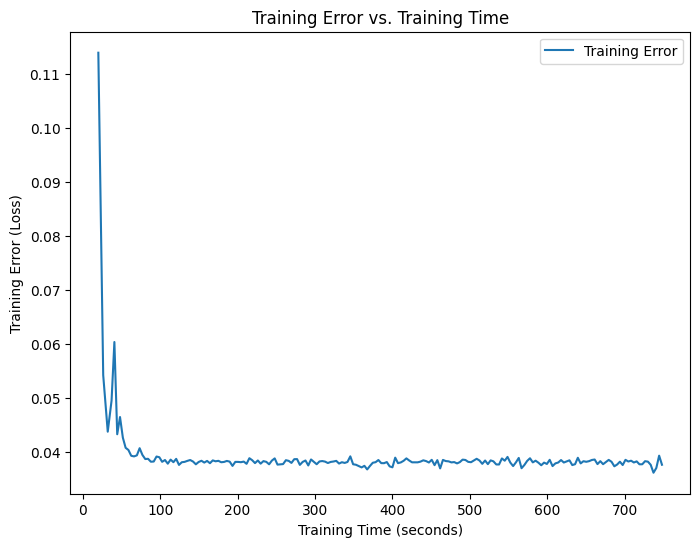

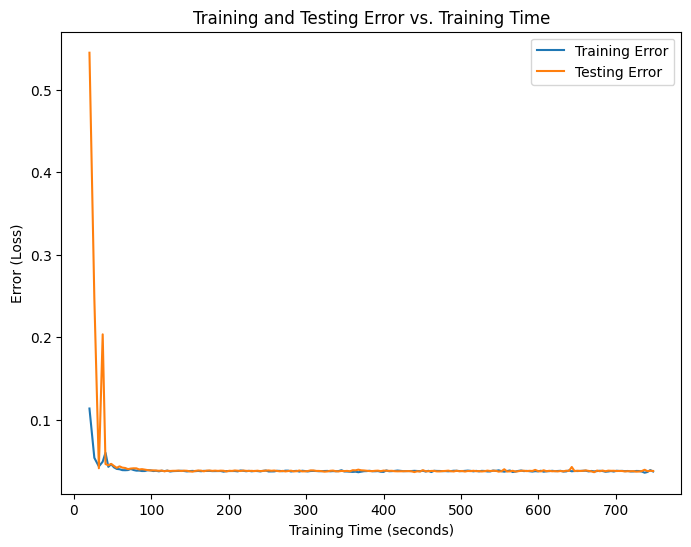

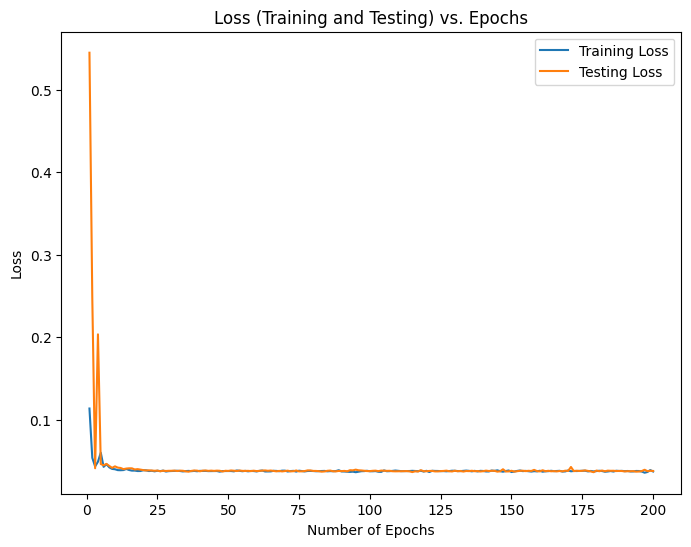

In [ ]:
# Graph-1: Training Error vs. Training Time
plt.figure(figsize=(8, 6)) # Figure Size
plt.plot(cumulative_training_time, training_loss, label='Training Error')
plt.xlabel('Training Time (seconds)')            # set x-label
plt.ylabel('Training Error (Loss)')              # set y-label
plt.title('Training Error vs. Training Time')    # set title
plt.legend()
plt.show()

# Graph-2: Training and Testing Error vs. Training Time
plt.figure(figsize=(8, 6))
plt.plot(cumulative_training_time, training_loss, label='Training Error')
plt.plot(cumulative_training_time, validation_loss, label='Testing Error')
plt.xlabel('Training Time (seconds)')                      # set x-label
plt.ylabel('Error (Loss)')                                 # set y-label
plt.title('Training and Testing Error vs. Training Time')  # set title
plt.legend()
plt.show()

# Graph-3: Loss (Training and Testing) vs. Epochs
epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Testing Loss')
plt.xlabel('Number of Epochs')                             # set x-label
plt.ylabel('Loss')                                         # set y-label
plt.title('Loss (Training and Testing) vs. Epochs')        # set title
plt.legend()
plt.show()